# Training on 125,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Wed Aug 30 13:45:45 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |   5655MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


### Load in the data.

In [4]:
%%time
modelpath   = "data/models/UNIF-10N-25T-125000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-125000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-3600E-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame
    del test_frame

Train takes up 1043560 bytes.
Test takes up 30120 bytes.
Train is list of 125000 events.
Test is list of 3600 events.
CPU times: user 46 s, sys: 1.08 s, total: 47.1 s
Wall time: 47 s


In [5]:
order = ["phi", "r", "z"]

### Show an example of the data.

In [ ]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

### Create the model.

In [6]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [7]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [8]:
%%time
# Current model has been trained on 68 epochs before early stopping.
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

Epoch 1/128
1250/1250 [==============================] - 1715s - loss: 0.4571 - acc: 0.8466 - val_loss: 0.2192 - val_acc: 0.9363
Epoch 2/128
1250/1250 [==============================] - 1681s - loss: 0.4472 - acc: 0.8511 - val_loss: 0.2186 - val_acc: 0.9365
Epoch 3/128
1250/1250 [==============================] - 1674s - loss: 0.4583 - acc: 0.8485 - val_loss: 0.2263 - val_acc: 0.9334
Epoch 4/128
1250/1250 [==============================] - 1670s - loss: 0.4742 - acc: 0.8435 - val_loss: 0.2180 - val_acc: 0.9357
Epoch 5/128
1250/1250 [==============================] - 1665s - loss: 0.4556 - acc: 0.8512 - val_loss: 0.2202 - val_acc: 0.9357
Epoch 6/128
1250/1250 [==============================] - 1668s - loss: 0.4421 - acc: 0.8565 - val_loss: 0.2186 - val_acc: 0.9367
Epoch 7/128
1250/1250 [==============================] - 1668s - loss: 0.4335 - acc: 0.8603 - val_loss: 0.2123 - val_acc: 0.9381
Epoch 8/128
1250/1250 [==============================] - 1665s - loss: 0.4358 - acc: 0.8598 - val

### Display information about the model after fitting it.

In [8]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 84.28678842852906%
Percent of tracks assigned correctly: 59.43125555414498%
Percent of events with the correct number of tracks: 80.75%
CPU times: user 1min 35s, sys: 152 ms, total: 1min 35s
Wall time: 1min 35s


In [11]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 5000 events with 1 tracks.
There are 5000 events with 2 tracks.
There are 5000 events with 3 tracks.
There are 5000 events with 4 tracks.
There are 5000 events with 5 tracks.
There are 5000 events with 6 tracks.
There are 5000 events with 7 tracks.
There are 5000 events with 8 tracks.
There are 5000 events with 9 tracks.
There are 5000 events with 10 tracks.
There are 5000 events with 11 tracks.
There are 5000 events with 12 tracks.
There are 5000 events with 13 tracks.
There are 5000 events with 14 tracks.
There are 5000 events with 15 tracks.
There are 5000 events with 16 tracks.
There are 5000 events with 17 tracks.
There are 5000 events with 18 tracks.
There are 5000 events with 19 tracks.
There are 5000 events with 20 tracks.
There are 5000 events with 21 tracks.
There are 5000 events with 22 tracks.
There are 5000 events with 23 tracks.
There are 5000 events with 24 tracks.
There are 5000 events with 25 tracks.


Percent of hits assigned correctly: 94.8051948051948%
Percent of tracks assigned correctly: 77.77777777777779%


<IPython.core.display.Javascript object>


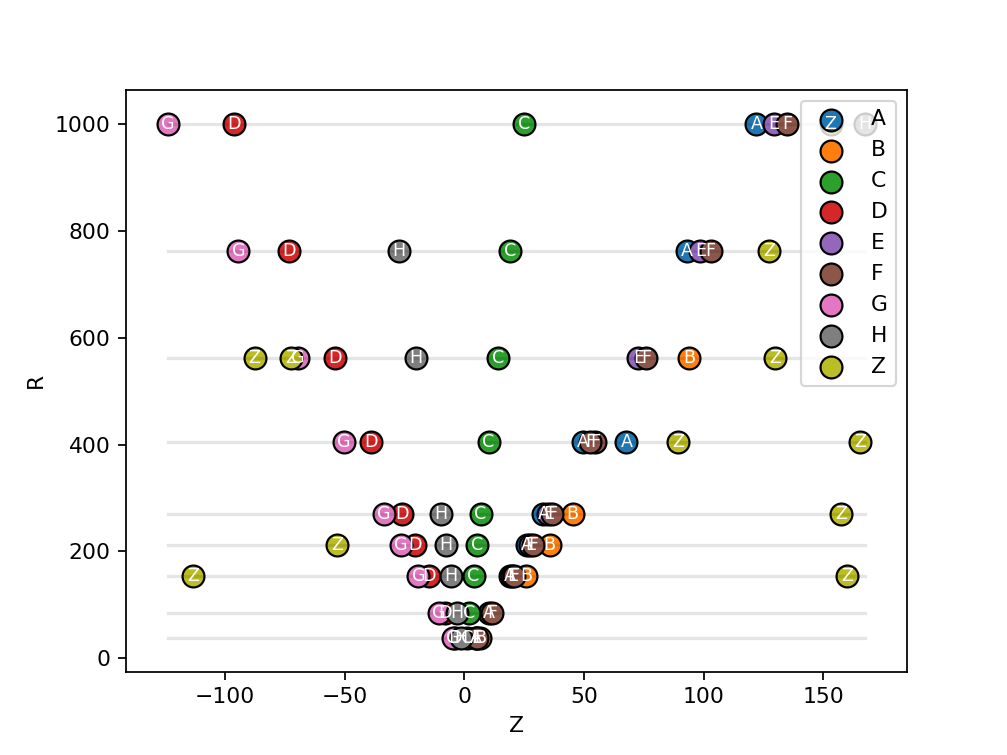

<IPython.core.display.Javascript object>


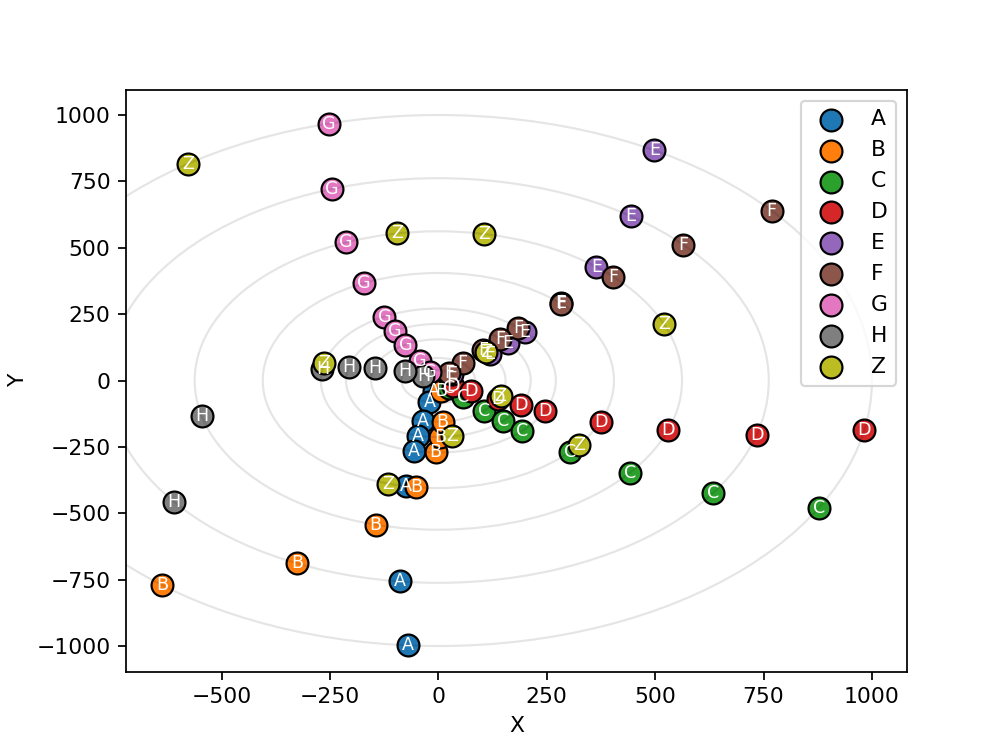

In [10]:
n = 10
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr")
_ = visuals.Plot2D(test[n], order).plot(mode="xy")

### Display the graphs.

<IPython.core.display.Javascript object>


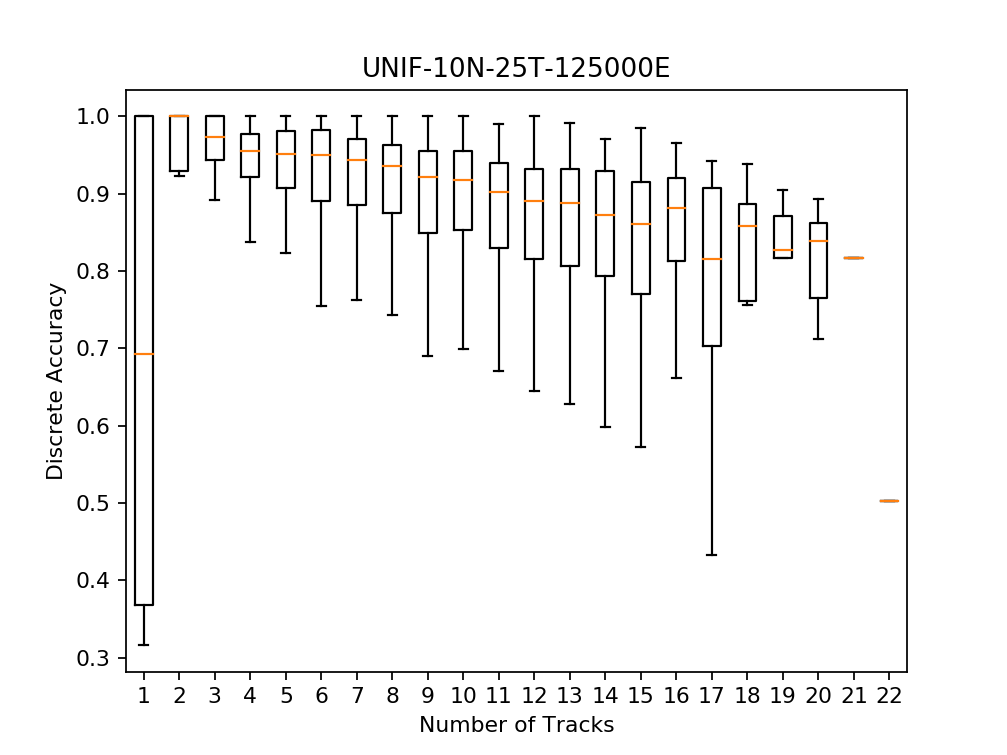

CPU times: user 30.6 s, sys: 8 ms, total: 30.6 s
Wall time: 30.6 s


In [12]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "UNIF-10N-25T-125000E", "Number of Tracks", "Discrete Accuracy", xticks=list(r))